In [59]:
import os
import sys
import pandas as pd
import yaml 
from matplotlib import pyplot as plt
import statsmodels.api as sm
import numpy as np
from itertools import product

with open("../../config.yaml.local", "r") as f:
    LOCAL_CONFIG = yaml.safe_load(f)
#with open("../../config.yaml", "r") as f:
#    CONFIG = yaml.safe_load(f)
sys.path.append("../python")

import globals
import data_tools as dt

LOCAL_PATH = LOCAL_CONFIG["LOCAL_PATH"]
RAW_DATA_PATH = LOCAL_CONFIG["RAW_DATA_PATH"]
DATA_PATH = LOCAL_CONFIG["DATA_PATH"]


In [60]:
tdf = dt.get_territory_by_day_panel()

In [61]:
tdf['week'] = tdf['date'].dt.to_period('W-SAT').dt.start_time

C:\Users\edwar\AppData\Local\Temp\ipykernel_50828\3594533189.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  tdf['week'] = tdf['date'].dt.to_period('W-SAT').dt.start_time


In [62]:
wdf = tdf.groupby(['subName', 'week']).agg(
    n_posts = ('n_posts', 'sum'),
    posting_fee = ('posting_fee', 'mean')
).reset_index()

wdf['subId'], uniques = pd.factorize(wdf['subName'])
wdf['weekId'], uniques = pd.factorize(wdf['week'])

In [63]:
#wdf.to_csv(os.path.join(DATA_PATH, "territory_by_week_panel.csv"), index=False)

In [64]:
fedf = pd.read_csv(os.path.join(DATA_PATH, "territory_by_week_fe.csv"))
sub_fe = fedf.loc[fedf['fe']=='subId'].reset_index(drop=True)
week_fe = fedf.loc[fedf['fe']=='weekId'].reset_index(drop=True)

sub_fe = sub_fe.rename(columns={'idx': 'subId'})
sub_fe['effect'] = sub_fe['effect'] - sub_fe['effect'].mean()
sub_fe = sub_fe.merge(
    wdf[['subId','subName']].drop_duplicates(), on='subId', how='left'
)
sub_fe = sub_fe.sort_values('effect', ascending=False).reset_index(drop=True)

week_fe = week_fe.rename(columns={'idx': 'weekId'})
week_fe = week_fe.merge(
    wdf[['weekId','week']].drop_duplicates(), on='weekId', how='left'
)
week_fe = week_fe.sort_values('week').reset_index(drop=True)
week_fe['effect'] = week_fe['effect'] - week_fe['effect'].iloc[0]


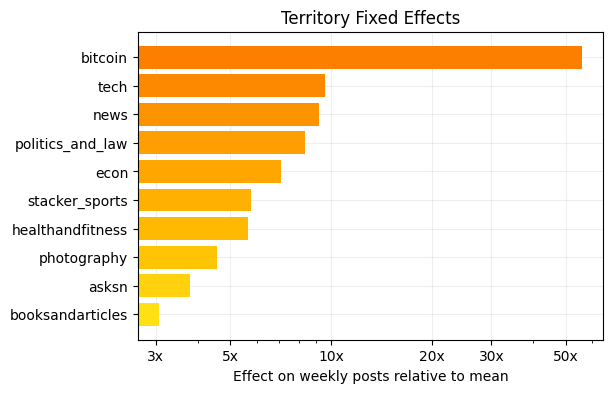

In [119]:
# territory fe chart
plot_df = sub_fe.head(10)
colors = plt.cm.Wistia(np.linspace(0.3,1,len(plot_df)))
plt.figure(figsize=(6,4))
plt.barh(plot_df['subName'][::-1], np.exp(plot_df['effect'][::-1])-1, color=colors)
plt.xscale('log')
plt.xticks([3, 5, 10, 20, 30, 50], ['3x', '5x', '10x', '20x', '30x', '50x'])
plt.xlabel("Effect on weekly posts relative to mean")
plt.title("Territory Fixed Effects")
plt.grid(alpha=0.2, zorder=0)
plt.gca().set_axisbelow(True)

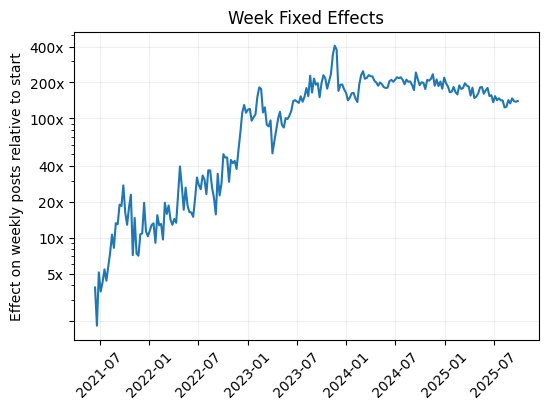

In [106]:
# weekly fe plot
plt.figure(figsize=(6,4))
plt.plot(week_fe['week'][1:-1], np.exp(week_fe['effect'][1:-1])-1)
plt.xticks(rotation=45)
plt.grid(alpha=0.2, zorder=0)
plt.gca().set_axisbelow(True)
plt.yscale('log')
plt.yticks([2, 5, 10, 20, 40, 100, 200, 400], ['', '5x', '10x', '20x', '40x', '100x', '200x', '400x'])
plt.ylabel('Effect on weekly posts relative to start')
plt.title('Week Fixed Effects')
plt.show()